NEW CONTEXT: HOSPITAL PATIENT DETERIORATION PREDICTION
Scenario: ICU Patient Health Risk Forecasting
A hospital ICU continuously monitors critical patient vitals.
The goal is to predict the patient’s risk score for the next 6 hours using the previous 12 hours of multivariate time-series data, so doctors can intervene before a medical emergency occurs.
🔹 Parameters Collected (Every Hour)
Feature	Description
heart_rate	Beats per minute
systolic_bp	Blood pressure (mmHg)
oxygen	Oxygen saturation (%)
resp_rate	Breaths per minute
temperature	Body temperature (°C)
🔹 Sample Dataset (12 Hours)
 
Hour	HR	BP	O₂	Resp	Temp
1	82	120	98	16	36.8
2	85	118	97	17	36.9
3	88	115	96	18	37.0
4	92	112	95	19	37.1
5	96	108	94	20	37.2
6	100	105	93	21	37.4
7	104	102	92	22	37.6
8	108	98	91	23	37.8
9	112	95	90	24	38.0
10	118	92	89	26	38.3
11	122	88	87	28	38.6
12	128	85	85	30	39.0

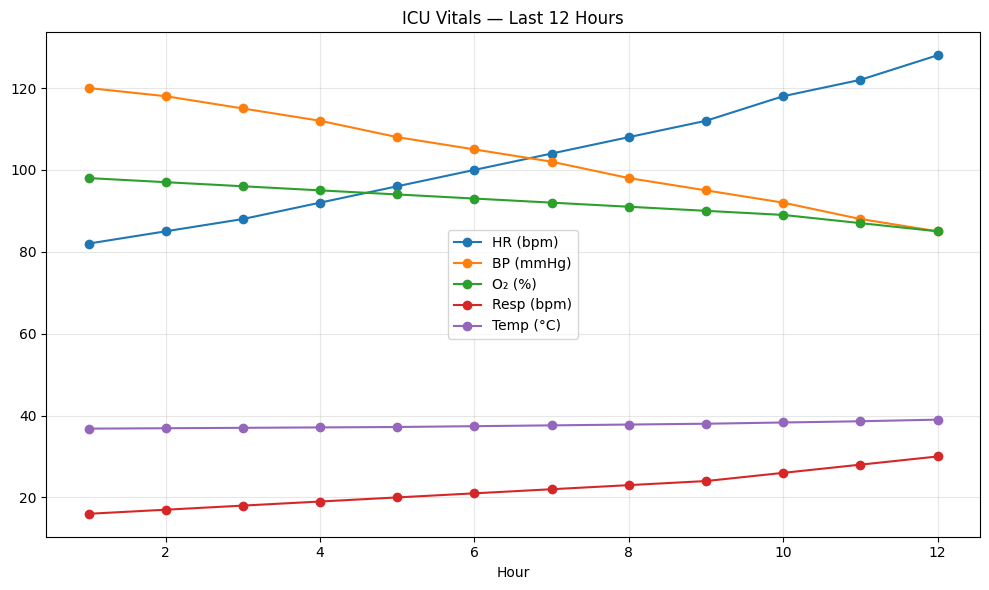

c:\Users\Pratik.Jadhav\Downloads\Training\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Predicted risk (next 6 hours) — SGD : [0.448 0.552 0.462 0.481 0.512 0.476]
Predicted risk (next 6 hours) — Adam: [0.533 0.517 0.481 0.555 0.526 0.462]


In [1]:



import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


tf.random.set_seed(1)
np.random.seed(1)

vitals_12h = np.array([
    [ 82, 120, 98, 16, 36.8],
    [ 85, 118, 97, 17, 36.9],
    [ 88, 115, 96, 18, 37.0],
    [ 92, 112, 95, 19, 37.1],
    [ 96, 108, 94, 20, 37.2],
    [100, 105, 93, 21, 37.4],
    [104, 102, 92, 22, 37.6],
    [108,  98, 91, 23, 37.8],
    [112,  95, 90, 24, 38.0],
    [118,  92, 89, 26, 38.3],
    [122,  88, 87, 28, 38.6],
    [128,  85, 85, 30, 39.0],
], dtype=np.float32)

FEATURE_NAMES = ["HR (bpm)", "BP (mmHg)", "O₂ (%)", "Resp (bpm)", "Temp (°C)"]
INPUT_LEN   = 12   # past hours
N_FEATURES  = 5    # HR, BP, O2, Resp, Temp
OUT_HORIZON = 6    # risk for next 6 hours


hours = np.arange(1, INPUT_LEN + 1)
plt.figure(figsize=(10, 6))
for i, name in enumerate(FEATURE_NAMES):
    plt.plot(hours, vitals_12h[:, i], marker='o', label=name)
plt.title("ICU Vitals — Last 12 Hours")
plt.xlabel("Hour")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


x_mean = vitals_12h.mean(axis=0, keepdims=True)
x_std  = vitals_12h.std(axis=0, keepdims=True) + 1e-8
X_in   = (vitals_12h - x_mean) / x_std
X_in   = X_in[np.newaxis, ...]  # shape: (1, 12, 5)


def build_model():
    model = Sequential([
        LSTM(32, input_shape=(INPUT_LEN, N_FEATURES)),
        Dense(16, activation='relu'),
        Dense(OUT_HORIZON, activation='sigmoid')  # risk in [0,1] for next 6 hours
    ])
    return model


opt_sgd  = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, clipnorm=1.0)
opt_adam = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)


model_sgd  = build_model()
model_adam = build_model()
model_sgd.compile(optimizer=opt_sgd,  loss='mse')
model_adam.compile(optimizer=opt_adam, loss='mse')


risk_sgd  = model_sgd.predict(X_in, verbose=0)[0]   # shape: (6,)
risk_adam = model_adam.predict(X_in, verbose=0)[0]  # shape: (6,)

print("Predicted risk (next 6 hours) — SGD :", np.round(risk_sgd,  3))
print("Predicted risk (next 6 hours) — Adam:", np.round(risk_adam, 3))

horizons = np.arange(1, OUT_HORIZON + 1)
width = 0.35
